In [2]:
# TO BE RUN ONLY ONCE!
import os
os.chdir("../")

In [3]:
## *******************************************************************************

In [4]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import subprocess
import pymc3 as pm
import seaborn as sns

import spatial_mix.hdp_utils as hdp_utils
from spatial_mix.utils import *
from spatial_mix.protos.py.univariate_mixture_state_pb2 import UnivariateState, UnivariateMixtureState, HdpState

current_palette = sns.color_palette()

In [5]:
from spatial_mix.protos.py.sampler_params_pb2 import SamplerParams
from google.protobuf import text_format

## Simulate data

<img src="simulation_scenario.png">

Simulate data as follows: for each little square we simulate data from a 3 components mixtures
$$ y_{ij} \sim w_{i1} N(-5, 1) + w_{i2} N(0, 1) + w_{i3} N(5, 1)$$

the weights depend on the location (x, y) of the center of the square (the orange dot)
$$ \widetilde{w}_{il} = \alpha_l x_i + \beta_l y_i \quad l=1, 2$$

finally $w_i = alr^{-1} ([\widetilde{w}_{i1}, \widetilde{w}_{i2}])$

In [6]:
def inv_alr(x):
    out = np.exp(np.hstack((x, 1)))
    return out / np.sum(out)

In [7]:
def simulate_from_mixture(weights, means=[-5, 0, 5]):
    comp = np.random.choice(3, p=weights)
    return np.random.normal(loc=means[comp], scale=1)

In [8]:
centers = np.array([[0, 1], [1, 1], [2, 1], [3, 1], [0, 0], [1, 0], [2, 0], [3, 0]])
centers = centers / 10
alpha1 = 0.3
alpha2 = -0.3
beta1 = 0.3
beta2 = -0.3

weights = []
for center in centers:
    w1 = alpha1 * center[0] + beta1 * center[1]
    w2 = alpha2 * center[0] + beta2 * center[1]
    weights.append(inv_alr([w1, w2]))

In [104]:
Dmat1 = np.zeros((8, 8))

for i in range(7):
    Dmat1[i, i+1] = 1
    Dmat1[i+1, i] = 1
    if (i < 4):
        Dmat1[i, i+4] = 1
        Dmat1[i+4, i] = 1
    
print(Dmat1)
# np.savetxt("data/simulated_D1.csv", Dmat1, delimiter=",")

[[0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0.]]


In [9]:
data = []
for i in range(8):
    numSamples = 100
    if i == 5:
        numSamples = 20
        
    for j in range(numSamples):
        data.append([i, simulate_from_mixture(weights[i])])
        
df = pd.DataFrame(data, columns=["group", "data"])
# df.to_csv("data/simulated_data1.csv", index=False)

In [10]:
# df = pd.read_csv("data/simulated_data2.csv")
datas = []
for g in range(8):
    datas.append(df[df.group == g].data.values)

burnin = 10000
niter = 10000
thin = 10

chains = runSpatialMixtureSampler(burnin, niter, thin, Dmat1,
                                  "spatial_mix/resources/sampler_params.asciipb", 
                                  datas)

Burn-in, iter # 200  /  10000
Burn-in, iter # 400  /  10000
Burn-in, iter # 600  /  10000
Burn-in, iter # 800  /  10000
Burn-in, iter # 1000  /  10000
Burn-in, iter # 1200  /  10000
Burn-in, iter # 1400  /  10000
Burn-in, iter # 1600  /  10000
Burn-in, iter # 1800  /  10000
Burn-in, iter # 2000  /  10000
Burn-in, iter # 2200  /  10000
Burn-in, iter # 2400  /  10000
Burn-in, iter # 2600  /  10000
Burn-in, iter # 2800  /  10000
Burn-in, iter # 3000  /  10000
Burn-in, iter # 3200  /  10000
Burn-in, iter # 3400  /  10000
Burn-in, iter # 3600  /  10000
Burn-in, iter # 3800  /  10000
Burn-in, iter # 4000  /  10000
Burn-in, iter # 4200  /  10000
Burn-in, iter # 4400  /  10000
Burn-in, iter # 4600  /  10000
Burn-in, iter # 4800  /  10000
Burn-in, iter # 5000  /  10000
Burn-in, iter # 5200  /  10000
Burn-in, iter # 5400  /  10000
Burn-in, iter # 5600  /  10000
Burn-in, iter # 5800  /  10000
Burn-in, iter # 6000  /  10000
Burn-in, iter # 6200  /  10000
Burn-in, iter # 6400  /  10000
Burn-in, ite

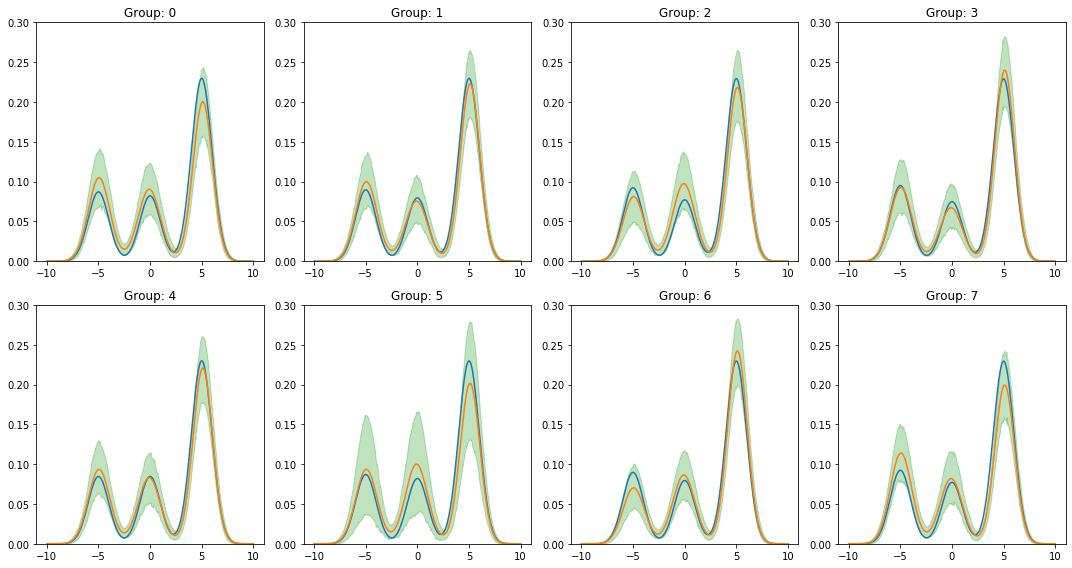

In [12]:
xgrid = np.linspace(-10, 10, 1000)
dens = estimateDensities(chains, xgrid)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    axes[g].set_ylim([0, 0.3])
    intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
#     sns.kdeplot(datas[g], ax=axes[g], color=current_palette[3])
    
plt.tight_layout()

In [13]:
estimateds = estimateDensities(chains, datas)
print(lpml(estimateds))
print(lpml(estimateds[5]))

80.68520079293427
2.2035647659221946


# Simulated Scenario 2

In [ ]:
Dmat2 = np.array([
    [0, 1, 1, 1, 0, 0, 0, 0],
    [1, 0, 1, 1, 0, 0, 0, 0],
    [1, 1, 0, 1, 0, 0, 0, 0],
    [1, 1, 1, 0, 0, 0, 0, 0],
    [0, 0, 0, 0, 0, 1, 1, 1],
    [0, 0, 0, 0, 1, 0, 1, 1],
    [0, 0, 0, 0, 1, 1, 0, 1],
    [0, 0, 0, 0, 1, 1, 1, 0]
]) 

print(Dmat2)

In [ ]:
w_group1 = np.array([0.25, 0.25, 0.5])
w_group2 = np.array([0.4, 0.4, 0.2])

weights = []

data = []
for i in range(8):
    w = w_group1 if i < 4 else w_group2
    weights.append(w)

In [ ]:
data = []
for i in range(8):
    numSamples = 100
    if i == 5:
        numSamples = 20

    for j in range(numSamples):
        data.append([i, simulate_from_mixture(weights[i])])
        
# df = pd.DataFrame(data, columns=["group", "data"])
# df.to_csv("data/simulated_data2.csv", index=False)
# np.savetxt("data/simulated_D2.csv", Dmat2, delimiter=",")

In [ ]:
df = pd.read_csv("data/simulated_data2.csv")
datas = []
for g in range(8):
    datas.append(df[df.group == g].data.to_list())

burnin = 10000
niter = 10000
thin = 10

chains = runSpatialMixtureSampler(burnin, niter, thin, Dmat2,
                                  "spatial_mix/resources/sampler_params.asciipb", 
                                  datas)

# Simulation Scenario 3

In [105]:
Dmat3 = np.zeros((8, 8))

for i in range(7):
    Dmat3[i, i+1] = 1
    Dmat3[i+1, i] = 1
    if (i < 4):
        Dmat3[i, i+4] = 1
        Dmat3[i+4, i] = 1
    
print(Dmat3)

[[0. 1. 0. 0. 1. 0. 0. 0.]
 [1. 0. 1. 0. 0. 1. 0. 0.]
 [0. 1. 0. 1. 0. 0. 1. 0.]
 [0. 0. 1. 0. 1. 0. 0. 1.]
 [1. 0. 0. 1. 0. 1. 0. 0.]
 [0. 1. 0. 0. 1. 0. 1. 0.]
 [0. 0. 1. 0. 0. 1. 0. 1.]
 [0. 0. 0. 1. 0. 0. 1. 0.]]


In [10]:
centers = np.array([[0, 1], [1, 1], [2, 1], [3, 1], [0, 0], [1, 0], [2, 0], [3, 0]])
centers = centers / 10
alpha1 = 0.3
alpha2 = -0.3
beta1 = 0.3
beta2 = -0.3

weights = []
for center in centers:
    w1 = alpha1 * center[0] + beta1 * center[1]
    w2 = alpha2 * center[0] + beta2 * center[1]
    weights.append(inv_alr([w1, w2]))

In [12]:
data = []
numSamples = 100
for i in range(6):

    for j in range(numSamples):
        data.append([i, simulate_from_mixture(weights[i], means=[-5, 0, 2])])

for j in range(numSamples):
    data.append([6, np.random.normal(5, 1)])
    
for j in range(numSamples):
    data.append([7, np.random.normal(5, 1)])
    
df = pd.DataFrame(data, columns=["group", "data"])

datas = []
for g in range(8):
    datas.append(df[df.group == g].data.values)
    
dissimilarities = [np.zeros((8, 8))] * 2

In [96]:
burnin = 10000
niter = 10000
thin = 10



chains = runSpatialMixtureSampler(burnin, niter, thin, Dmat3,
                                  "spatial_mix/resources/sampler_params.asciipb", 
                                  datas, dissimilarities)

Burn-in, iter # 200  /  10000
Burn-in, iter # 400  /  10000
Burn-in, iter # 600  /  10000
Burn-in, iter # 800  /  10000
Burn-in, iter # 1000  /  10000
Burn-in, iter # 1200  /  10000
Burn-in, iter # 1400  /  10000
Burn-in, iter # 1600  /  10000
Burn-in, iter # 1800  /  10000
Burn-in, iter # 2000  /  10000
Burn-in, iter # 2200  /  10000
Burn-in, iter # 2400  /  10000
Burn-in, iter # 2600  /  10000
Burn-in, iter # 2800  /  10000
Burn-in, iter # 3000  /  10000
Burn-in, iter # 3200  /  10000
Burn-in, iter # 3400  /  10000
Burn-in, iter # 3600  /  10000
Burn-in, iter # 3800  /  10000
Burn-in, iter # 4000  /  10000
Burn-in, iter # 4200  /  10000
Burn-in, iter # 4400  /  10000
Burn-in, iter # 4600  /  10000
Burn-in, iter # 4800  /  10000
Burn-in, iter # 5000  /  10000
Burn-in, iter # 5200  /  10000
Burn-in, iter # 5400  /  10000
Burn-in, iter # 5600  /  10000
Burn-in, iter # 5800  /  10000
Burn-in, iter # 6000  /  10000
Burn-in, iter # 6200  /  10000
Burn-in, iter # 6400  /  10000
Burn-in, ite

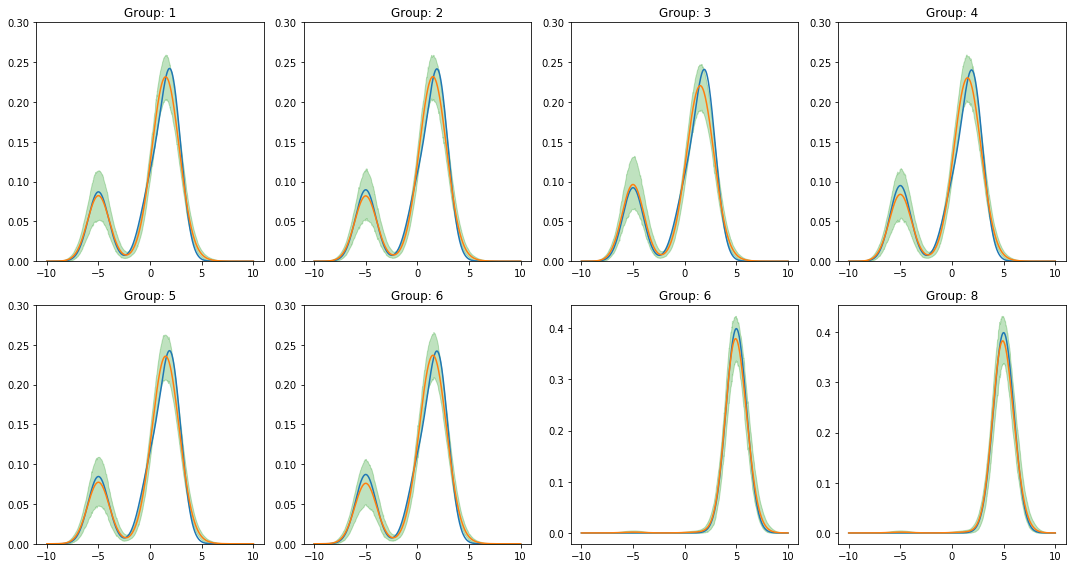

In [97]:
xgrid = np.linspace(-10, 10, 1000)
dens = estimateDensities(chains, xgrid)

fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(6):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 2.0, 1.0))
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    axes[g].set_ylim([0, 0.3])
    intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g+1))

axes[6].plot(xgrid, norm.pdf(xgrid, 5, 1.0))
axes[6].plot(xgrid, np.mean(dens[6], 0))
intervals = np.array([pm.stats.hpd(dens[6][:, i], 0.05) for i in range(dens[6].shape[1])])
axes[6].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
axes[6].set_title("Group: {0}".format(6))
    

axes[7].plot(xgrid, norm.pdf(xgrid, 5, 1.0))
axes[7].plot(xgrid, np.mean(dens[7], 0))
intervals = np.array([pm.stats.hpd(dens[7][:, i], 0.05) for i in range(dens[7].shape[1])])
axes[7].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
axes[7].set_title("Group: {0}".format(7+1))
    
plt.tight_layout()

In [98]:
allB = np.vstack(list(map(lambda x: chains[x].boundaries.data, range(len(chains)))))
bounds = np.mean(allB, axis=0).reshape(8, 8)
print(bounds)

[[0.    0.706 0.    0.    0.703 0.    0.    0.   ]
 [0.706 0.    0.704 0.    0.    0.723 0.    0.   ]
 [0.    0.704 0.    0.792 0.    0.    0.    0.   ]
 [0.    0.    0.792 0.    0.781 0.    0.    0.   ]
 [0.703 0.    0.    0.781 0.    0.717 0.    0.   ]
 [0.    0.723 0.    0.    0.717 0.    0.    0.   ]
 [0.    0.    0.    0.    0.    0.    0.    1.   ]
 [0.    0.    0.    0.    0.    0.    1.    0.   ]]


In [99]:
def plot_neighbors(mat):
    for i in range(8):
        xc = centers[i][0] * 10
        yc = centers[i][1] * 10

        plt.plot([xc, xc], [yc, yc+1], color="black", alpha=0.1)   # left
        plt.plot([xc, xc + 1], [yc, yc], color="black", alpha=0.1) # bottom
        plt.plot([xc + 1, xc + 1], [yc, yc + 1], color="black", alpha=0.1) #right
        plt.plot([xc, xc + 1], [yc + 1, yc + 1], color="black", alpha=0.1) # up


        if (i < 3):
            # guardo quello a dx
            plt.plot([xc + 1, xc + 1], [yc, yc + 1], color=current_palette[0], alpha=mat[i, i+1])
            # guardo quello in basso
            plt.plot([xc, xc + 1], [yc, yc], color=current_palette[0], alpha=mat[i, i+4])

        if (i == 3):
            plt.plot([xc, xc + 1], [yc, yc], color=current_palette[0], alpha=mat[i, i+1])

        if (i > 3 and i < 7):
            # guardo quello a dx
            plt.plot([xc + 1, xc + 1], [yc, yc + 1], color=current_palette[0], alpha=mat[i, i+1])

In [94]:
dmat_true = Dmat3
dmat_true[:, 6] = np.zeros(8)
dmat_true[:, 7] = np.zeros(8)
dmat_true[6, :] = np.zeros(8)
dmat_true[6, 7] = 1
dmat_true[7, :] = np.zeros(8)
dmat_true[7, 6] = 1

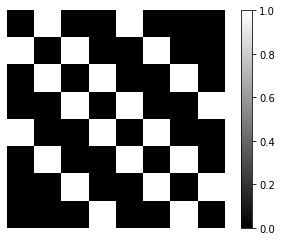

In [106]:
plt.imshow(Dmat3, cmap="gist_gray")
plt.colorbar()
plt.axis("off")
# plt.savefig("images/simulation_3_boundaries_H4.pdf")
plt.show()

In [103]:
Dmat3

array([[0., 1., 0., 0., 1., 0., 0., 0.],
       [1., 0., 1., 0., 0., 1., 0., 0.],
       [0., 1., 0., 1., 0., 0., 0., 0.],
       [0., 0., 1., 0., 1., 0., 0., 0.],
       [1., 0., 0., 1., 0., 1., 0., 0.],
       [0., 1., 0., 0., 1., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0., 1.],
       [0., 0., 0., 0., 0., 0., 1., 0.]])

## Plot density estimates

In [ ]:
# df = pd.read_csv("data/simulated_data2.csv")
# chains = loadChains("data/chains_simulated2.recordio")

In [ ]:
# datas = []
# for g in range(8):
#     datas.append(df[df.group == g].data.to_list())

In [ ]:
# chains 

In [109]:
xgrid = np.linspace(-10, 10, 1000)
dens = estimateDensities(chains, xgrid)

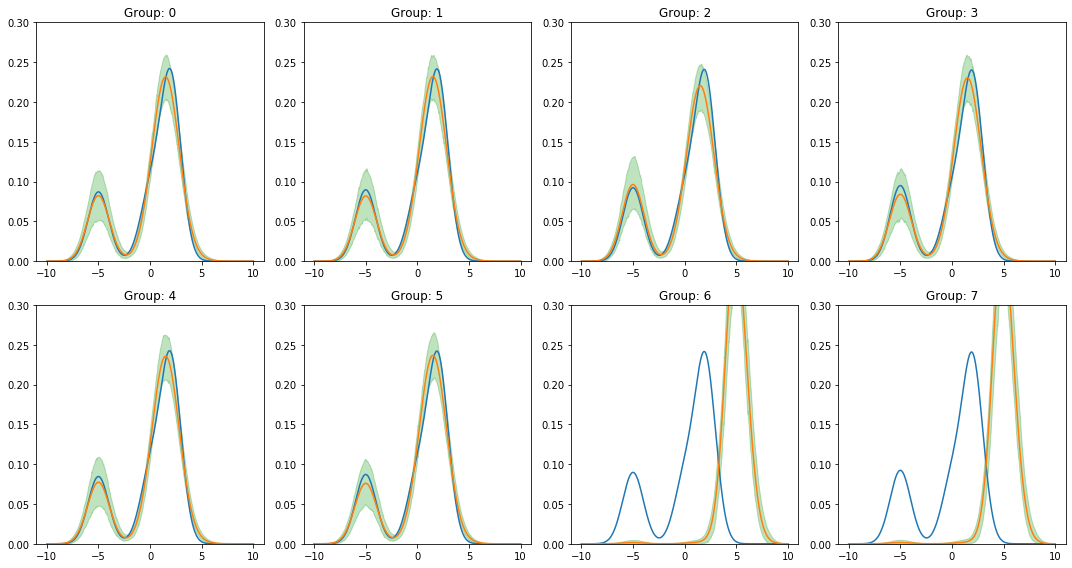

In [111]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 2.0, 1.0))
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    axes[g].set_ylim([0, 0.3])
    intervals = np.array([pm.stats.hpd(dens[g][:, i], 0.05) for i in range(dens[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
#     sns.kdeplot(datas[g], ax=axes[g], color=current_palette[3])
    
plt.tight_layout()

In [ ]:
estimateds = estimateDensities(chains, datas)
lpml(estimateds)

In [ ]:
chains[0].rho

In [ ]:
## Plot RhoChain
rhoChain = list(map(lambda x: x.rho, chains))
plt.plot(range(len(chains)), rhoChain)

In [ ]:
Wmat = Dmat2.astype(np.double)

## Hdp

In [ ]:
subprocess.call(
    "./spatial_mix/run_hdp_from_file.out"
    " data/simulated_data1.csv"
    " data/chains_hdp_simulated1.recordio".split())

In [ ]:
hdpChains = loadChains("data/chains_hdp_simulated1.recordio", HdpState)

In [ ]:
xgrid = np.linspace(-10, 10, 1000)
densHdp = hdp_utils.estimateDensities(hdpChains, xgrid)

In [ ]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(15, 8))
axes = axes.flat

for g in range(8):
    axes[g].plot(xgrid, 
                 weights[g][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[g][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[g][2] * norm.pdf(xgrid, 5.0, 1.0))
    obs = df[df["group"] == g]["data"].values
    # sns.kdeplot(obs, ax=axes[g])
    axes[g].set_ylim([0, 0.3])
    axes[g].plot(xgrid, np.mean(dens[g], 0))
    intervals = np.array([pm.stats.hpd(densHdp[g][:, i], 0.05) for i in range(densHdp[g].shape[1])])
    axes[g].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
    axes[g].set_title("Group: {0}".format(g))
    
plt.tight_layout()

In [ ]:
# Plot comparing the estimated densities
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(8, 3))

# Our
axes[0].plot(xgrid, 
                 weights[5][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[5][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[5][2] * norm.pdf(xgrid, 5.0, 1.0))
obs = df[df["group"] == g]["data"].values
axes[0].set_ylim([0, 0.3])
# axes[0].plot(xgrid, np.mean(dens[5], 0))
intervals = np.array([pm.stats.hpd(dens[5][:, i], 0.05) for i in range(dens[5].shape[1])])
axes[0].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[2])
axes[0].set_title("Spatial Mixtures")

# hdp
axes[1].plot(xgrid, 
                 weights[5][0] * norm.pdf(xgrid, -5, 1.0) +
                 weights[5][1] * norm.pdf(xgrid, 0.0, 1.0) +
                 weights[5][2] * norm.pdf(xgrid, 5.0, 1.0))
obs = df[df["group"] == g]["data"].values
axes[1].set_ylim([0, 0.3])
# axes[1].plot(xgrid, np.mean(densHdp[5], 0))
intervals = np.array([pm.stats.hpd(densHdp[5][:, i], 0.05) for i in range(densHdp[5].shape[1])])
axes[1].fill_between(xgrid, intervals[:, 0], intervals[:, 1], alpha=0.3, color=current_palette[3])
axes[1].set_title("HDP")

plt.tight_layout()
plt.savefig("images/sim_1_densities.pdf")